# Gradient Boosting Machines for Wine Points Predictions

Wine Spectator's 100-Point Scale

95-100 Classic: a great wine.

90-94 Outstanding: a wine of superior character and style.

85-89 Very good: a wine with special qualities.

80-84 Good: a solid, well-made wine.

75-79 Mediocre: a drinkable wine that may have minor flaws.

50-74 Not recommended.

In [1]:
!pip install xgboost

    100% |████████████████████████████████| 114.0MB 472kB/s 
You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install graphviz

You are using pip version 10.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import RegexpTokenizer
import xgboost as xgb

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [5]:
#Load data
wine = pd.read_csv('data/winemag-data_first150k.csv', index_col=0, encoding="utf-8")
wine.dropna(subset=["price"], inplace=True)
wine.reset_index(inplace=True, drop=True)
print(wine.shape)
wine.head()

(137235, 10)


,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [17]:
wine[['description', 'price', 'points']].sample(15)

,description,price,points
22824,an unusual wine for sicily sallier de la tour ...,30.0,88
118799,this cab based bordeaux blend is very dense in...,50.0,89
132570,soft and round but with structure and spine th...,23.0,89
80129,scents of cherry and raspberry sauce unfold on...,14.0,85
129413,all this wine wants to be is a useful friendly...,9.0,84
37072,here s a silky pinot noir that s ready to drin...,42.0,90
114237,with no oak there s nothing but bright searing...,19.0,87
60882,savory and a step up compared to the rest of c...,14.0,88
374,grippy leather and tobacco provide a gravelly ...,28.0,90
92305,this wine features a unique combination of sto...,17.0,87


In [8]:
wine["description"][0]

'This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.'

In [9]:
print(wine.points.max())
print(wine.points.min())

100
80


min points 80
max points100


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


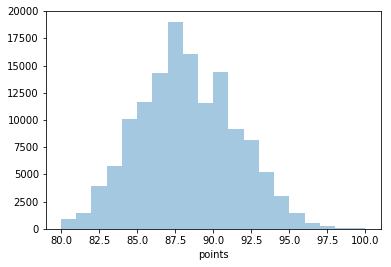

In [10]:
print("min points {}".format(wine.points.min()))
print("max points{}".format(wine.points.max()))

sns.distplot(wine.points, bins=20, kde=False)
plt.show()

# Feature Engineering

In [11]:
def ohe_features(df, feature, occurances):
    '''
    df: pandas data frame with feature to be encoded
    feature: str. feature name
    occurances: number of occurances to threshold feature at
    '''
    vc = df[feature].value_counts()
    keep_values = vc[vc > occurances].index.tolist()
    ohe_feature = pd.get_dummies(df[feature])

    feature_names = ohe_feature.columns
    keep_features = feature_names[feature_names.isin(keep_values)]
    return ohe_feature[keep_features]

def make_lower_case(text):
    return text.lower()

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text

In [12]:
country = pd.get_dummies(wine.country)
collist = country.columns.tolist()
collist = ["country_" + s for s in collist]
country.columns = collist
print ("There are {} country categorical variables".format(country.shape[1]))

designation = ohe_features(wine, "designation", 50)
collist = designation.columns.tolist()
collist = ["designation_" + s for s in collist]
designation.columns = collist
print ("There are {} designation categorical variables".format(designation.shape[1]))

province = ohe_features(wine, "province", 50)
collist = province.columns.tolist()
collist = ["province_" + s for s in collist]
province.columns = collist
print ("There are {} province categorical variables".format(province.shape[1]))

region = ohe_features(wine, "region_1", 50)
collist = region.columns.tolist()
collist = ["region_" + s for s in collist]
region.columns = collist
print ("There are {} region categorical variables".format(region.shape[1]))

variety = ohe_features(wine, "variety", 50)
collist = variety.columns.tolist()
collist = ["variety_" + s for s in collist]
variety.columns = collist
print ("There are {} variety categorical variables".format(variety.shape[1]))

winery = ohe_features(wine, "winery", 50)
collist = winery.columns.tolist()
collist = ["winery_" + s for s in collist]
winery.columns = collist
print ("There are {} winery categorical variables".format(winery.shape[1]))

There are 46 country categorical variables
There are 71 designation categorical variables
There are 113 province categorical variables
There are 308 region categorical variables
There are 133 variety categorical variables
There are 454 winery categorical variables


In [13]:
wine["description"] = wine["description"].str.replace('\d+', '')
wine["description"] = wine.description.apply(func=remove_punctuation)
wine["description"] = wine.description.apply(func=make_lower_case)

In [14]:
tf = TfidfVectorizer(analyzer='word', 
                     min_df=10,
                     ngram_range=(1, 2),
                     stop_words='english')
svd = TruncatedSVD(n_components=5)

#Fit tfidf and svd, and transform training data
tfidf_matrix = tf.fit_transform(wine.description)
lsa_features = pd.DataFrame(svd.fit_transform(tfidf_matrix))
collist = map(str, range(0, 5))
collist = ["latent_description_" + s for s in collist]
lsa_features.columns = collist
lsa_features.head()

,latent_description_0,latent_description_1,latent_description_2,latent_description_3,latent_description_4
0,0.122660,-0.036944,-0.007851,-0.023449,-0.028573
1,0.135296,-0.041430,0.016480,-0.010557,0.005033
2,0.077102,0.047091,-0.014918,-0.005658,0.009037
3,0.147137,-0.097017,0.032873,-0.001220,0.026520
4,0.083745,0.001448,-0.080751,-0.100291,-0.024101


In [16]:
X = pd.concat([lsa_features, wine["price"]], axis=1)
y = wine["points"]
print (X.shape)
print (y.shape)

(137235, 6)
(137235,)


# Test Train Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

print ("{} training observations".format(X_train.shape[0]))
print ("{} testing observations".format(X_test.shape[0]))

96064 training observations
41171 testing observations


# XGBoost Classification

In [19]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [20]:
param = {'max_depth': 3, 'eta': 1, 'subsample':0.5, 'alpha':1}
param['nthread'] = 4
param['eval_metric'] = 'mae'
param['objective'] = 'reg:linear'
param['silent'] = 1
evallist = [(dtrain, 'train')]
num_round = 10

In [21]:
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10)

[0]	train-mae:2.07006
Will train until train-mae hasn't improved in 10 rounds.
[1]	train-mae:1.97986
[2]	train-mae:1.94716
[3]	train-mae:1.9257
[4]	train-mae:1.90304
[5]	train-mae:1.88801
[6]	train-mae:1.87019
[7]	train-mae:1.86545
[8]	train-mae:1.85998
[9]	train-mae:1.85575


In [22]:
pred = pd.DataFrame(y_test.copy())
pred["prediction"] = bst.predict(dtest, ntree_limit=bst.best_ntree_limit)
pred["prediction"] = np.round(pred["prediction"],0).astype(int)
pred.sample(5)

,points,prediction
82036,87,89
99239,90,89
65138,83,88
85905,93,88
52871,87,88


In [23]:
from sklearn.metrics import median_absolute_error, mean_absolute_error
mean_ae = np.round(mean_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
median_ae = np.round(median_absolute_error(y_true=pred["points"], y_pred=pred["prediction"]),2)
print ("Mean Absolute Error: {} points".format(mean_ae))

Mean Absolute Error: 1.84 points


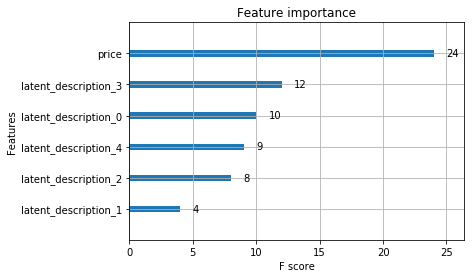

In [24]:
xgb.plot_importance(bst,max_num_features=15)

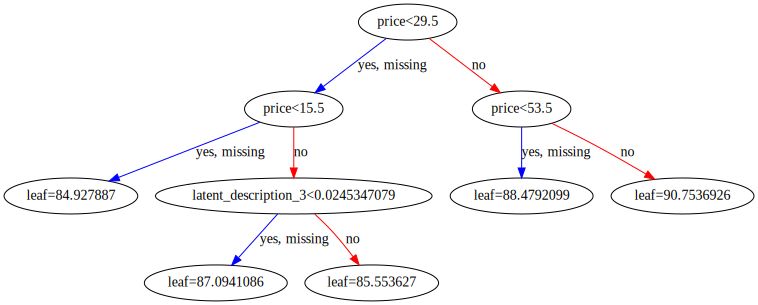

In [25]:
xgb.to_graphviz(bst, num_trees=0)

In [ ]:
from sklearn.externals import joblib

In [ ]:
joblib.dump(bst, "testmodel")
print("Model trained and saved!")

In [ ]:
bst = joblib.load("testmodel")

# DIY Deployment

In [ ]:
# I wrote my own predict method 
# Use business logic to filter predictions, not just the models basic predict
# send info in and out as a dictionary/json

In [ ]:
def my_own_predict_method(feature_payload):
    
    message_cheap = "Wow, what a steal!"
    message_expensive = "Yikes, that is a spendy wine!"

    #format payload as a dataframe
    x = pd.DataFrame(feature_payload, index=[0])
    #convert it to xgboost data object
    x = xgb.DMatrix(x, label=y_test)

    #predict wine price from xgboost model
    prediction = bst.predict(x, ntree_limit=bst.best_ntree_limit)
    prediction = np.round(prediction,2)[0]
 
    #personalise message 
    if prediction < 50:
        message = message_cheap
    else:
        message = message_expensive
        
    output = {"price": "$"+str(prediction), "message":message}
    
    return output

In [ ]:
#get an example payload from the test data
feature_payload = X_test.iloc[5].to_dict()
print(feature_payload)

In [ ]:
non_zero_features = [k for k,v in feature_payload.items() if v > 0]
dict((k, feature_payload[k]) for k in non_zero_features if k in feature_payload)

In [ ]:
my_own_predict_method(feature_payload)